# Environment Settings

In [2]:
# modelling
import pandas as pd
import numpy as np
import mlflow
from functools import reduce

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import  TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries 
from darts.utils.callbacks import TFMProgressBar
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta, NBEATSModel, ARIMA, RNNModel
from darts.metrics import mape

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

In [3]:
# Plotting
from IPython.display import display, HTML, clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_columns', 500)
pd.options.plotting.backend = "plotly"

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 10]

import seaborn as sns; sns.set()
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.4)

# UDF
User Defined Functions

In [4]:
def corr_triplot(input_df, add_title, file_path):
    ''' Create correlation plots of input dataframe and individual TS plots
    
    '''
    
    pd.options.plotting.backend = 'matplotlib'
    # Generate a mask for the upper triangle
    corr_data = input_df.corr()
    mask = np.zeros_like(corr_data, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    fig = plt.figure(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax1 = plt.subplot2grid((len(input_df.columns), 4), (0, 0), rowspan=len(input_df.columns)-1, colspan=2)
    sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='0.2f', ax=ax1)
    
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.title('{0} features correlations and plots'.format(add_title))
    
    for i, j in enumerate(input_df.columns):
        input_df[j].plot(title=j, ax=plt.subplot2grid((len(input_df.columns), 4), (i, 2), colspan=2))


    plt.tight_layout()
    plt.savefig(file_path, dpi=100)

# calculate the impact
def decomposition_impact(df):
    
    var_Rt = df.resid.var(skipna=True)
    var_Tt_Rt = (df.trend + df.resid).var(skipna=True)
    var_St_Rt = (df.seasonal + df.resid).var(skipna=True)
    
    Ft = max(0, (1-(var_Rt/var_Tt_Rt)))
    Fs = max(0, (1-(var_Rt/var_St_Rt)))
    
    return Ft, Fs

# calculate the share
def decomposition_share(df):
    df_total = pd.DataFrame()
    df_total['observed'] = df.observed
    df_total['trend'] = df.trend
    df_total['seasonal'] = df.seasonal
    df_total['resid'] = df.resid
    df_total.dropna(how='any', axis=0, inplace=True)
#     print(df_total.head(3))
    trend_share = 100* df_total['trend'].max()/df_total['observed'].max()
    season_share = 100* df_total['seasonal'].max()/df_total['observed'].max()
    resid_share = 100 - (trend_share+season_share)
    share_list = [trend_share, season_share, resid_share]
    
    return share_list

# decomposition plot
def decomp_plot(df_col, output_path, model='additive', period=12):
    
    pd.options.plotting.backend = 'matplotlib'
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12,12))
    
    result = seasonal_decompose(df_col.dropna(how='any'), model=model, period=period)
    a, b, c = decomposition_share(result)
    Ft, Fs = decomposition_impact(result)
    
    result.observed.plot(ax=axes[0], legend=False, title='Decomposition of "{}"'.format(df_col.name))
    axes[0].set_ylabel('Observed')
    result.trend.plot(ax=axes[1], legend=False, title='{0:.1f}% share, Strength: {1:.2f}'.format(a, Ft))
    axes[1].set_ylabel('Trend')
    result.seasonal.plot(ax=axes[2], legend=False, title='{0:.1f}% share, Strength: {1:.2f}'.format(b, Fs))
    axes[2].set_ylabel('Seasonal')
    result.resid.plot(ax=axes[3], style=".", legend=False, title='{0:.1f}% share'.format(c))
    axes[3].set_ylabel('Residual')
    
    fig.tight_layout()
    plt.savefig(output_path, dpi=100)
    return result

def eval_model(train_df, model):
    ''' Evaluate TS models with K-fold style CV

    input
    -----
    train_df: dataframe for training
    model: selected forecast model

    output
    ------
    avg_score: avg MAPE score

    '''

    ts_models = []
    fold = 0
    scores = []


    for train_idx, val_idx in tss.split(train_df):
        train_data = train_df.iloc[train_idx]
        val_data = train_df.iloc[val_idx]

        train = TimeSeries.from_series(train_data)
        val = TimeSeries.from_series(val_data)

        print(f'{fold + 1}. Fold Training... ')
        fold += 1
        model.fit(train)
        ts_models.append(model)
        pred = model.predict(len(val))
        score = mape(val, pred)
        scores.append(score)

        # print(f'Test score => {score}')
        print("model {} obtains MAPE: {:.2f}%".format(model, score))

    avg_score = np.average(scores)
    print(f'CV MAPE score => {avg_score}')
    return(avg_score)

def transform_plot(
    m, forcast, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6)
):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    forcast_t = forcast['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), np.exp(m.history['y']-1), 'k.') # 1+np.exp(forecast['yhat'])  
    ax.plot(forcast_t, np.exp(forcast['yhat']-1), ls='-', c='#0072B2')
    if 'cap' in forcast and plot_cap:
        ax.plot(forcast_t, forcast['cap'], ls='--', c='k')
    if m.logistic_floor and 'floor' in forcast and plot_cap:
        ax.plot(forcast_t, forcast['floor'], ls='--', c='k')
    if uncertainty:
        ax.fill_between(forcast_t, np.exp(forcast['yhat_lower']-1), np.exp(forcast['yhat_upper']-1),
                        color='#0072B2', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig

def error_plot(input_df, forecast, title, file_path, transform=False):
    
    
    metric_df = forecast.set_index('ds')[['yhat']].join(input_df.set_index('ds').y).reset_index()
    # metric_df.shape
    metric_df.dropna(inplace=True)
    # metric_df.tail()
    if transform:
        metric_df[['yhat', 'y']] = metric_df[['yhat', 'y']].apply(lambda x: np.exp(x-1), axis=1) #np.exp(fcst['yhat_upper']-1)
    
    
    model_errors = metric_df.y - metric_df.yhat
    r2 = r2_score(metric_df.y, metric_df.yhat)
    model_mape = 100.0 * mean_absolute_percentage_error(metric_df.y, metric_df.yhat)
    # print(model_mape)

    # plotting
    plt.rcParams['figure.figsize'] = (18, 22)

    fig = plt.figure(figsize=(18, 22))
    ax1 = plt.subplot2grid((3, 3), (0, 1), colspan=2)
    
    metric_df.y.plot(label='Raw Data', ax=ax1)
    metric_df.yhat.plot(label='Prediction', ax=ax1)
    
    # anchored_text = AnchoredText(results.params.to_string(), 
    #                              prop=dict(size=10), 
    #                              frameon=True, 
    #                              loc='upper left', 
    #                              bbox_to_anchor=(-0.65, 0.6),
    #                              bbox_transform=ax1.transAxes)
    # ax1.add_artist(anchored_text)
    ax1.legend()
    ax1.set(title='{0} Modelling; R$^2$: {1:.2f}; MAPE: {2:.1f}%'.format(title, r2, model_mape))
    
    ax2 = plt.subplot2grid((3, 3), (1, 1), colspan=2, sharex = ax1)
    model_errors.plot(ax = ax2, title='Model Errors')
    
    ax3 = plt.subplot2grid((3, 3), (1, 0), colspan=1)
    sns.distplot(a=model_errors, ax=ax3, rug=True)
    ax3.set(title='Model Errors Distribution')
    
    ax4 = plt.subplot2grid((3, 3), (2, 1), colspan=2)
    sm.graphics.tsa.plot_acf(model_errors.squeeze(), lags=40, ax=ax4)
    ax4.set(title='Errors Autocorrelation')
    sns.despine(bottom = True, left = True)

    plt.tight_layout()
    fig.savefig('{0}'.format(file_path), dpi=100)
    mlflow.log_figure(fig, '{0}'.format(file_path))
    
    return metric_df

# Question II: TS Forecasting

In the attached file sales.csv there is weekly sales of individual product types.

+ What can be said about the overall trend and seasonality of sales? What of the individual product type?
+ Are there correlations between sales of some product types, and if so, which?
+ Select a single product type and make forecast about its sales for 5 time periods
(weeks) from the last observed data point. Please include confidence interval of this forecast.


## EDA

In [5]:
df = pd.read_csv('./sales.csv', parse_dates=[0]).set_index('date')
df['Total'] = df.sum(axis=1)
df
df.plot(template='plotly_dark')

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt,Total
date,,,,,,,,
2018-09-27,19194,21046,12573,10720,3309,9791,26523,103156
2018-10-04,13292,14721,6916,7645,2557,6981,17594,69706
2018-10-11,19954,20708,7495,9138,3632,9956,23666,94549
2018-10-18,17547,20016,7913,9693,3565,7894,20586,87214
2018-10-25,17420,20397,8887,12132,3415,7495,19395,89141
...,...,...,...,...,...,...,...,...
2020-08-13,10351,29723,2574,2782,9064,8874,19223,82591
2020-08-20,11852,25028,6210,6211,4999,7635,21342,83277
2020-08-27,11851,19010,9540,8123,2417,6746,17373,75060


In [6]:
# checking the flucation in terms of the max/min sales in a year
(100 *(df.groupby(df.index.year).max() - df.groupby(df.index.year).min()))//df.groupby(df.index.year).max()

,Blouse,Dress,Hoodie,Jacket,Shorts,Skirt,T-shirt,Total
date,,,,,,,,
2018,51,51,61,58,56,41,61,46
2019,78,84,85,82,98,77,87,81
2020,74,81,91,72,95,74,70,75


## Answer I

+ Total sales have yearly peaks around last spring and summer (April, May, June, July) and secondary peaks in Oct and end of November
+ Those peaks are mostly likely due to holiday seasons (Easter, Christmas, etc.) and sales promotions
+ Summer groups are Shorts and T-shirt, and winter groups are Blouse, Dress, Hoodie, Jacket, and Skirt
+ Seasonal clothes flucates much more than all-season types, e.g., Shorts has very minimum sales in winter and vis verse for Hoodie and Jacket in summer

## Correlations

+ plotting the individual ts and their correlation heatmap

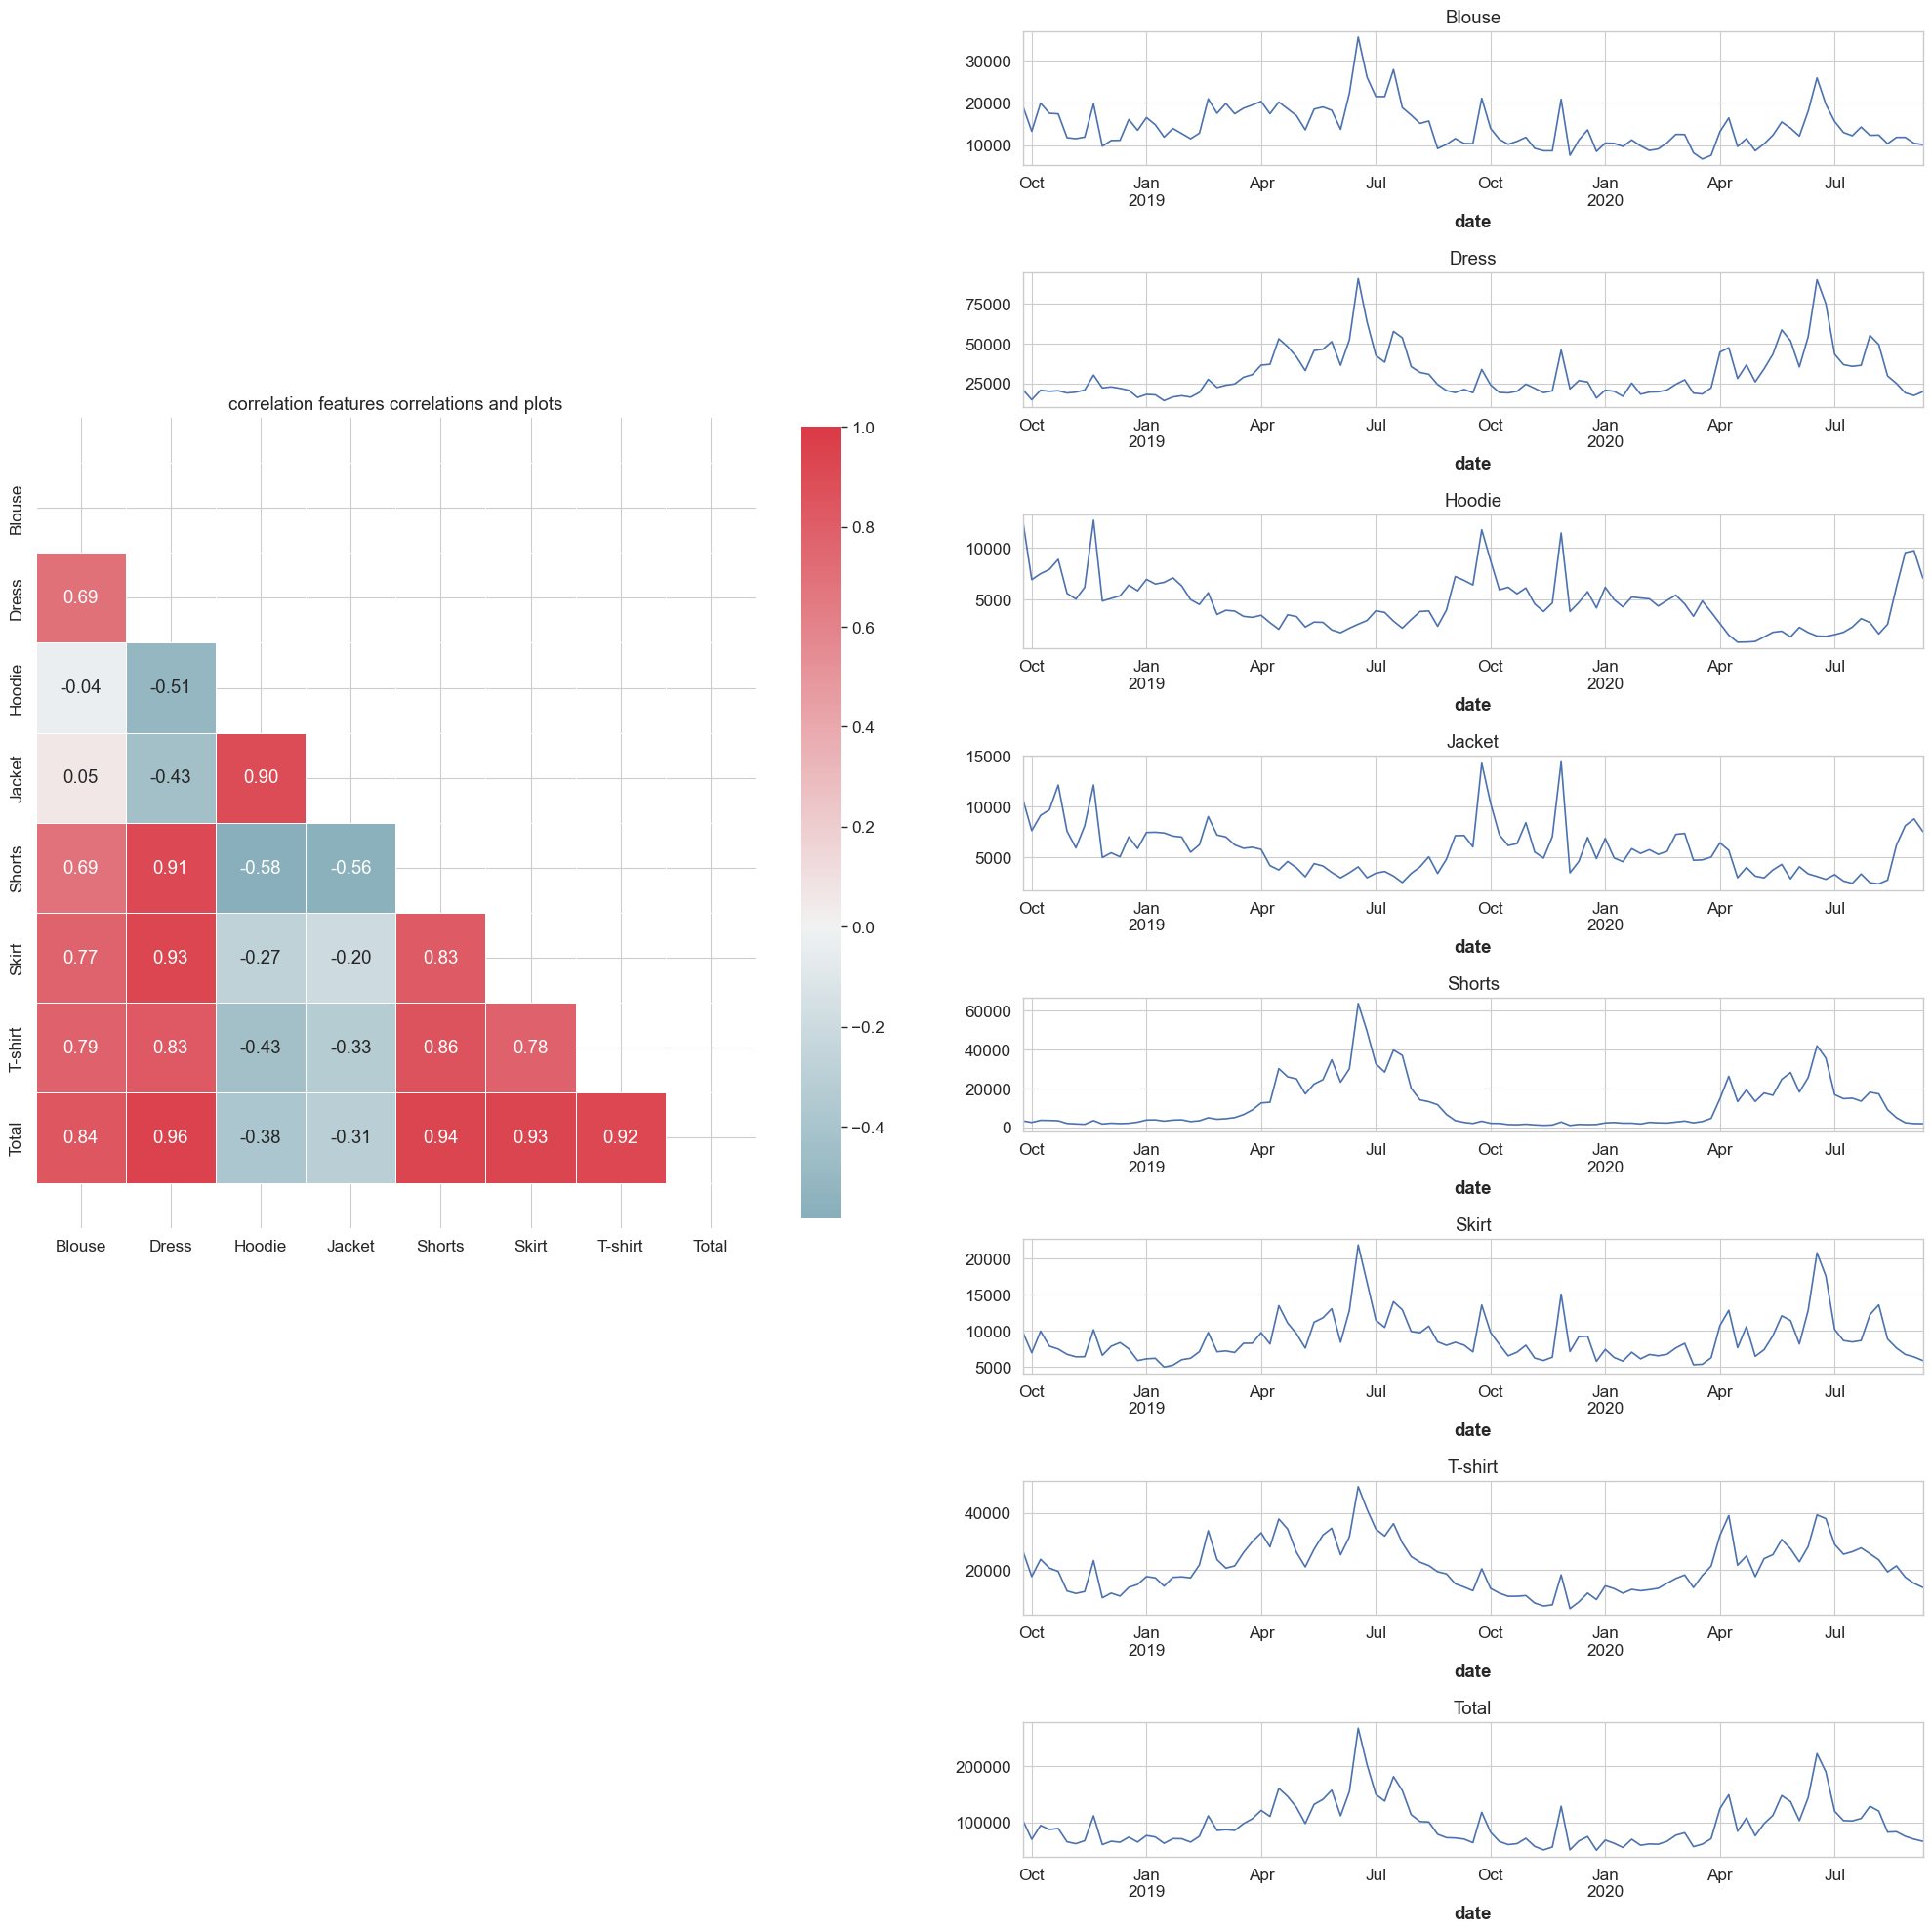

In [7]:
corr_triplot(df, 'correlation', 'img/corr.png')

Blouse 4


Dress 4


Hoodie 8


Jacket 4


Shorts 0
Skirt 4


T-shirt 4


Total 4


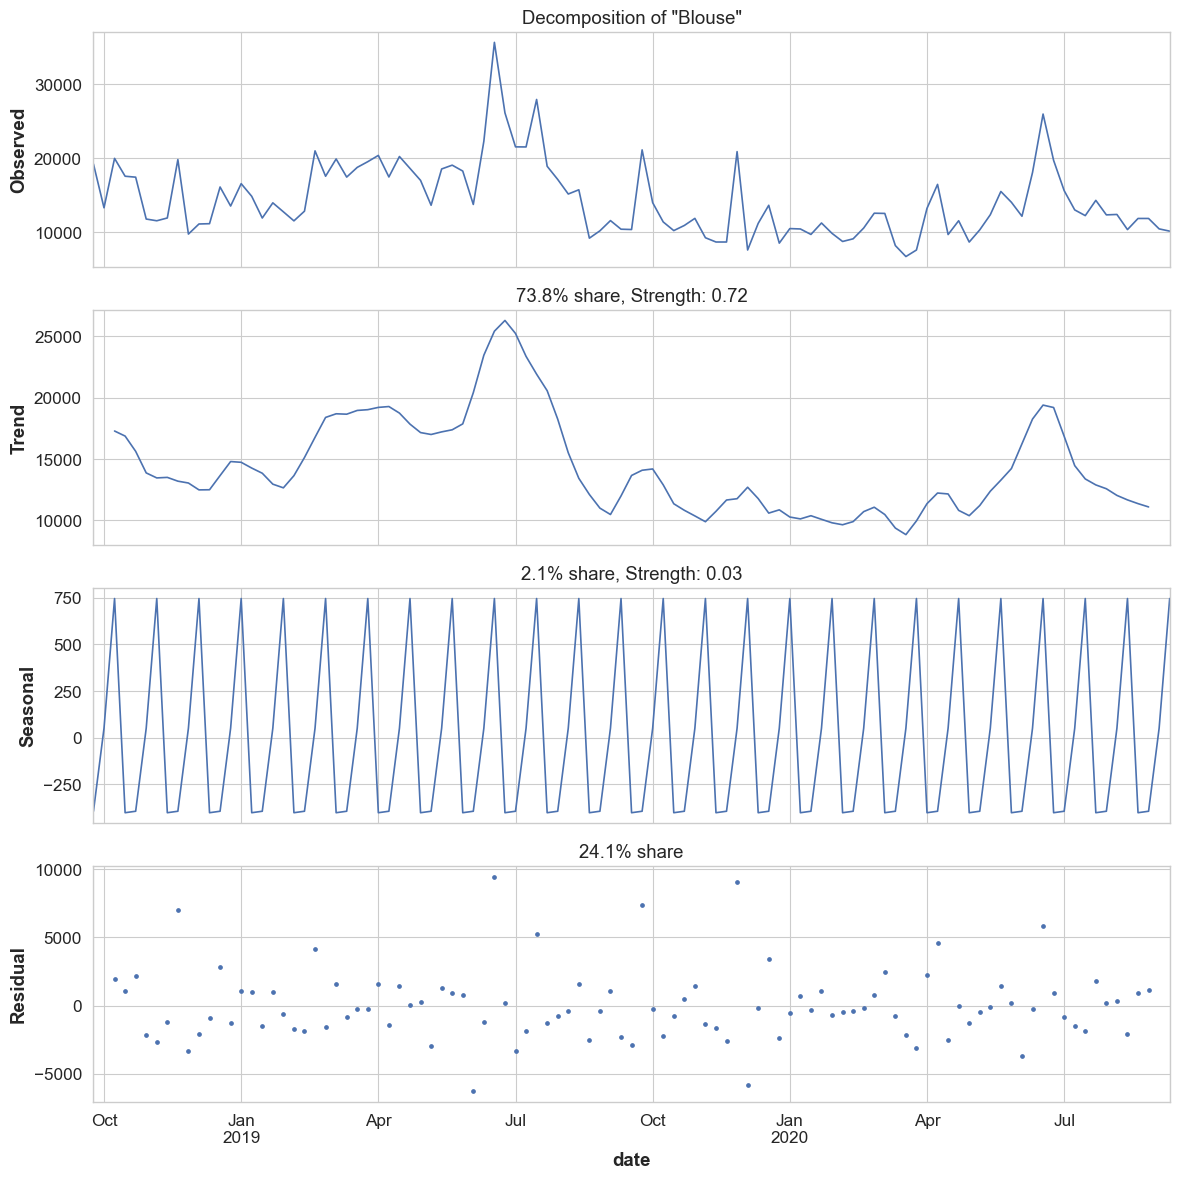

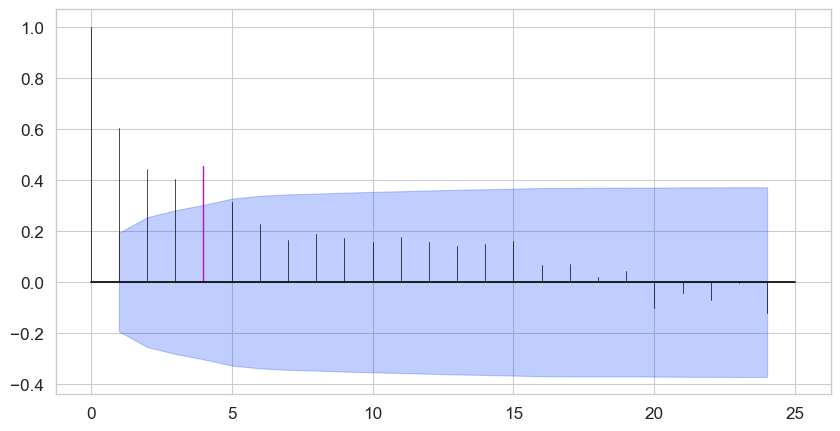

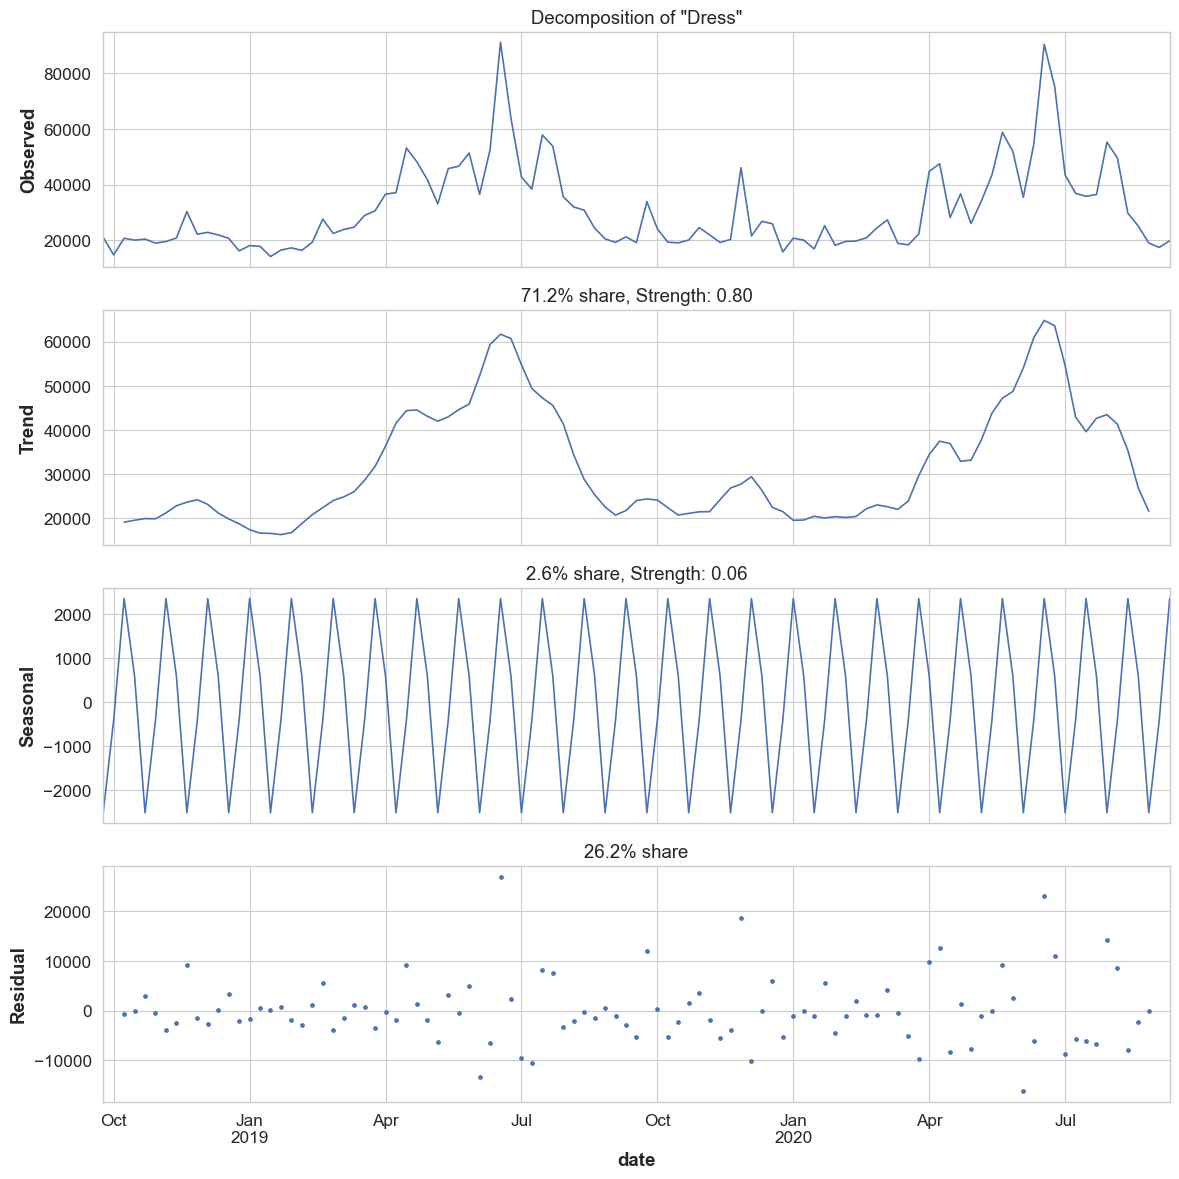

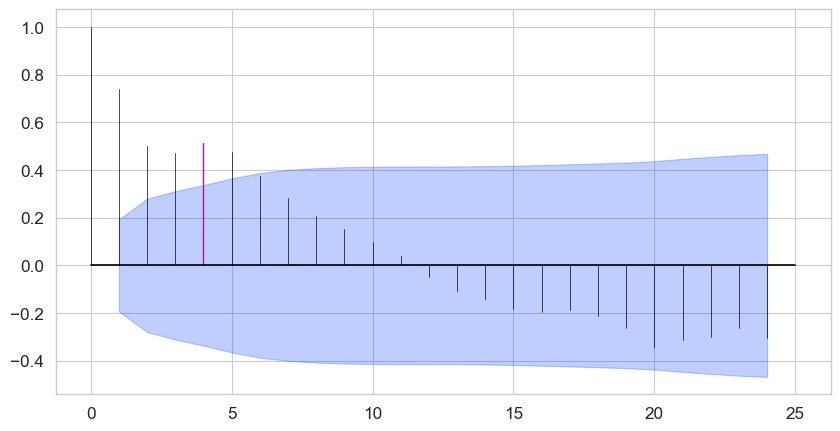

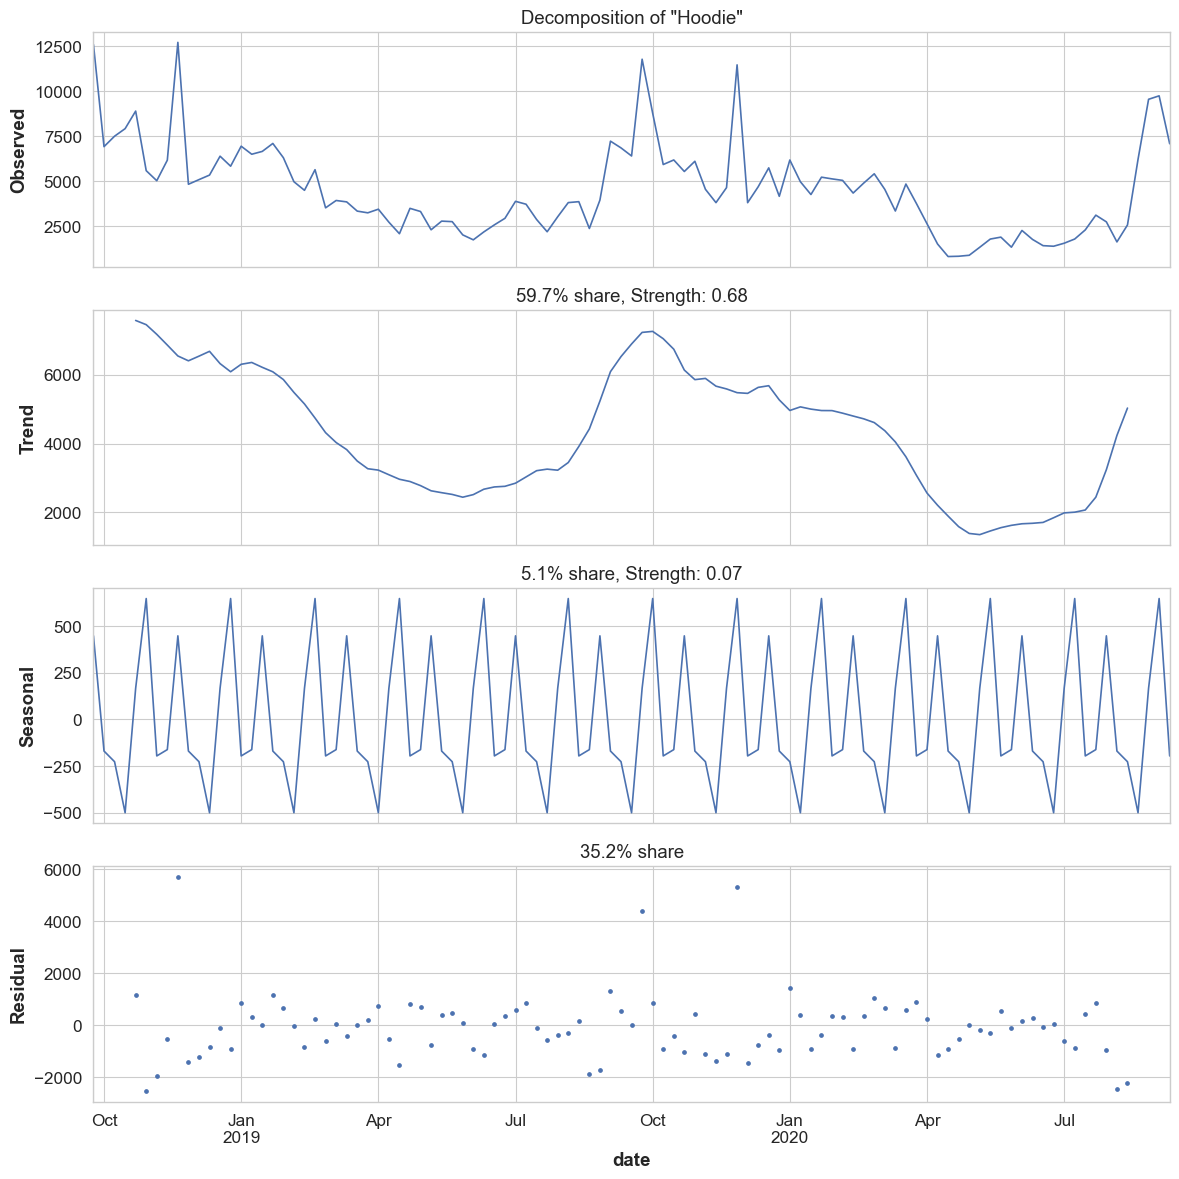

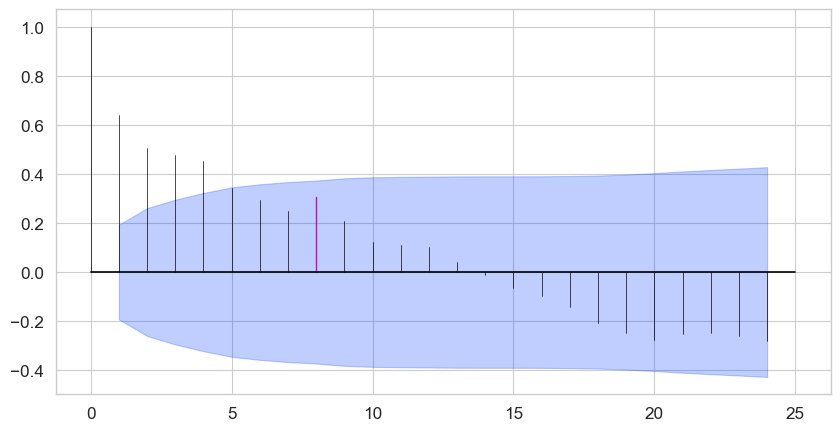

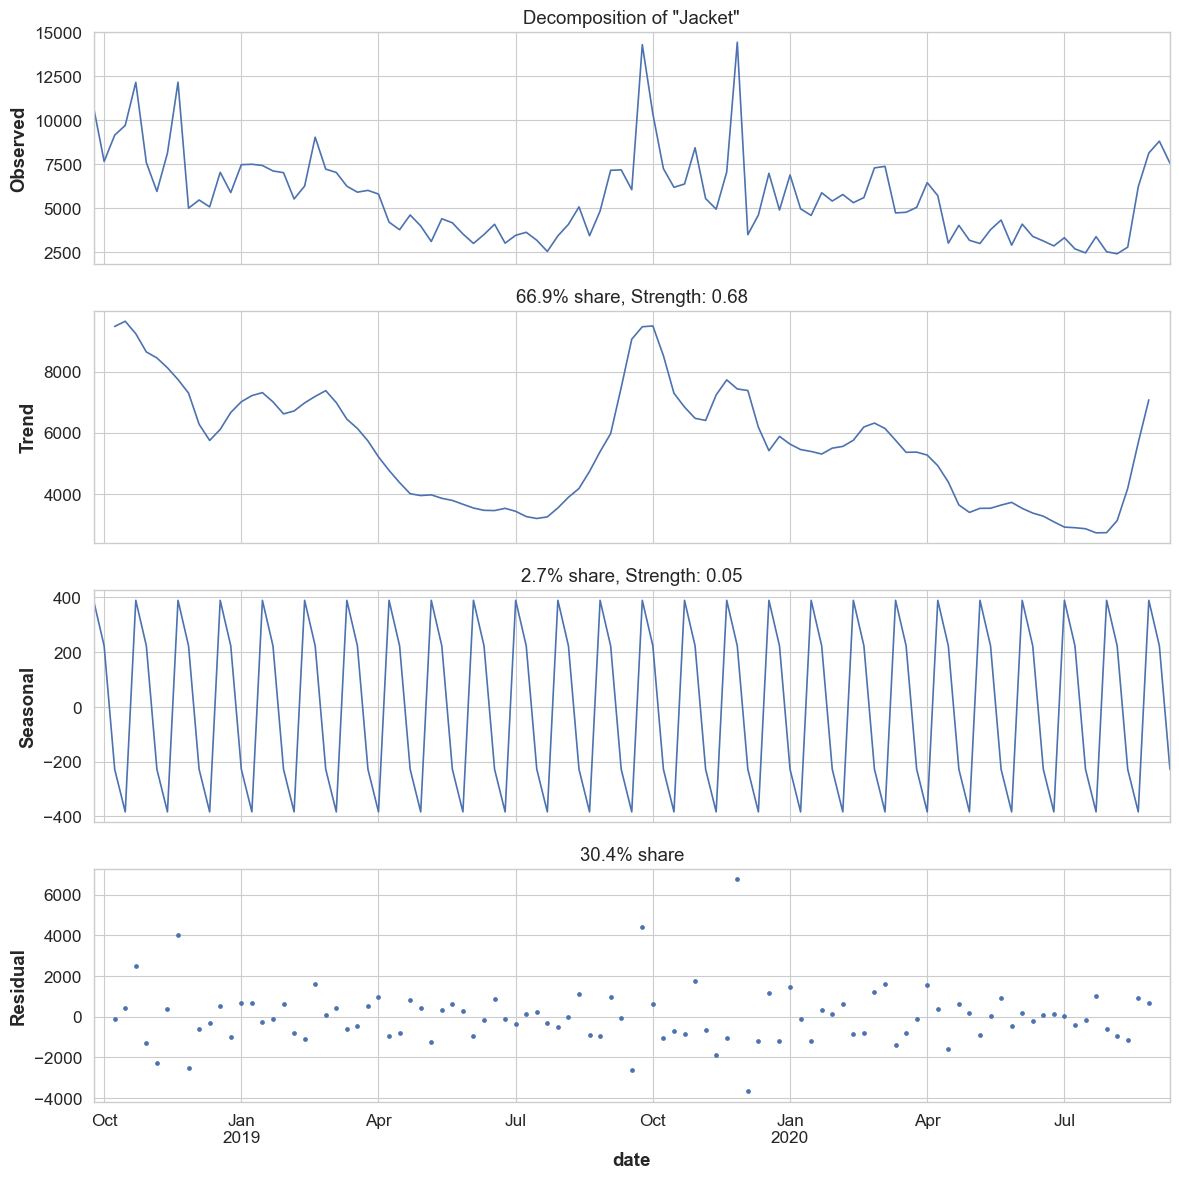

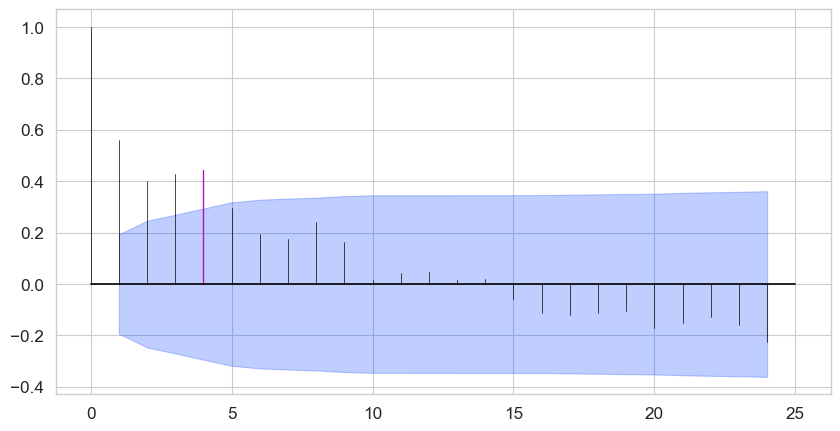

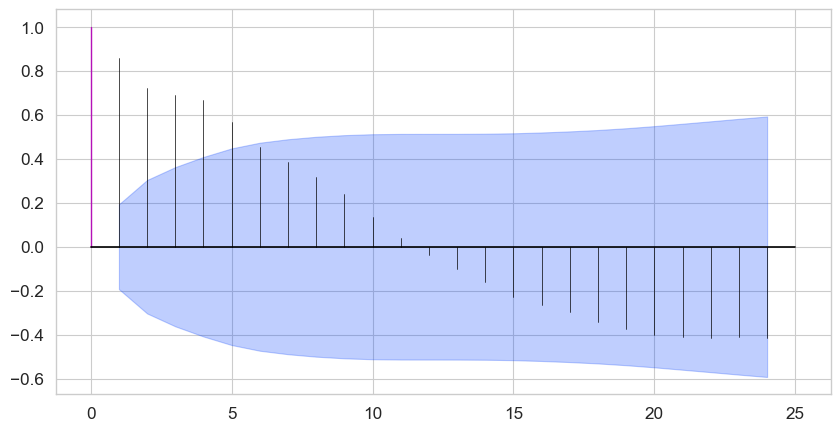

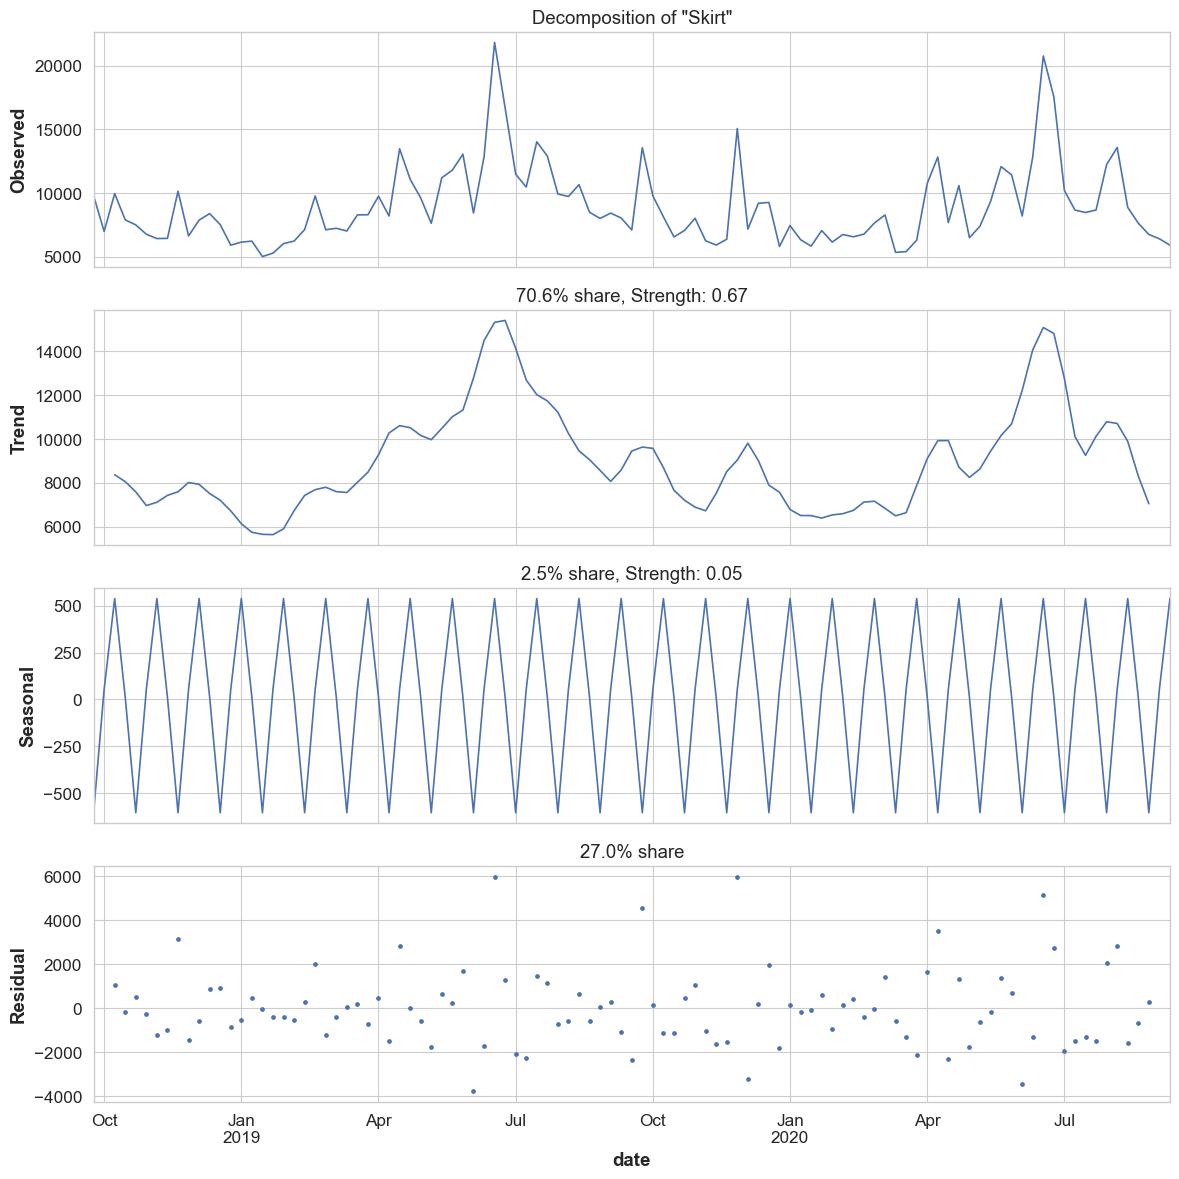

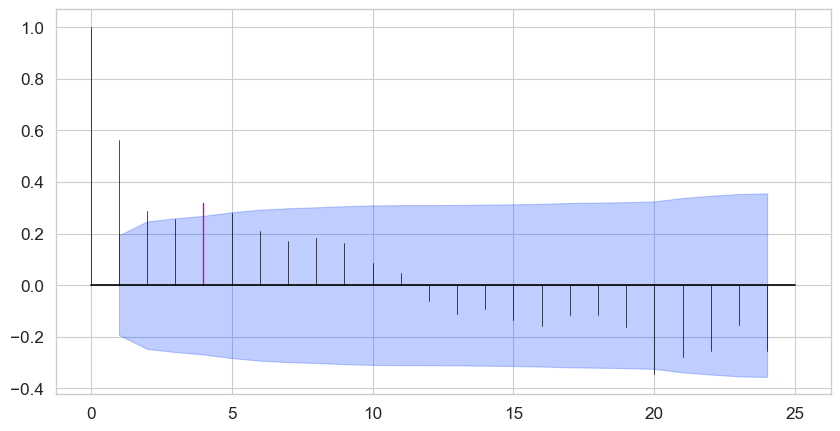

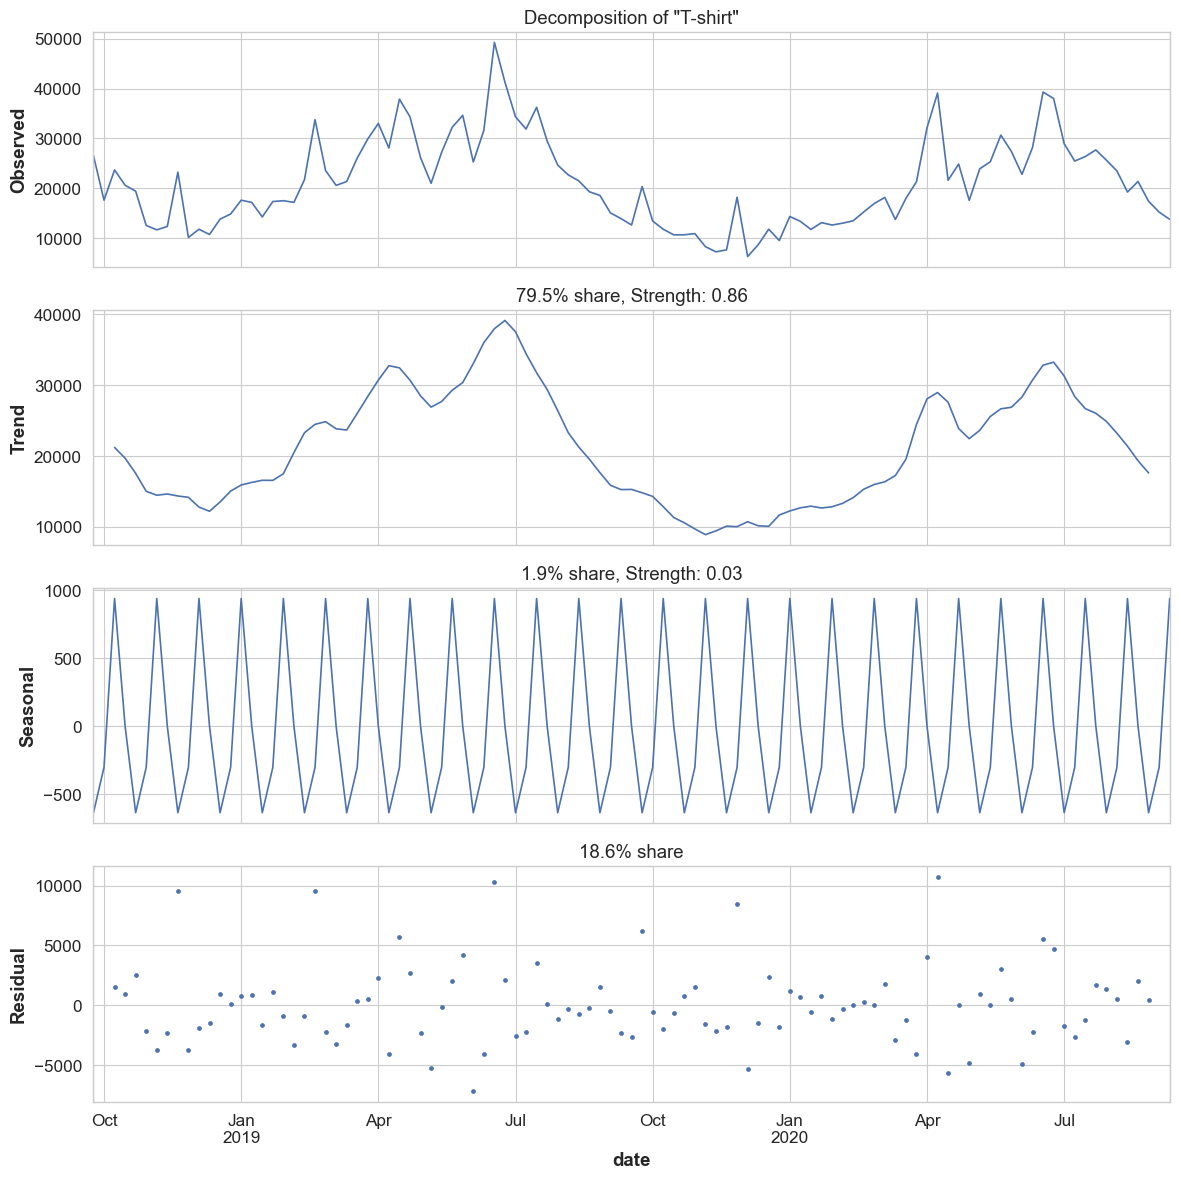

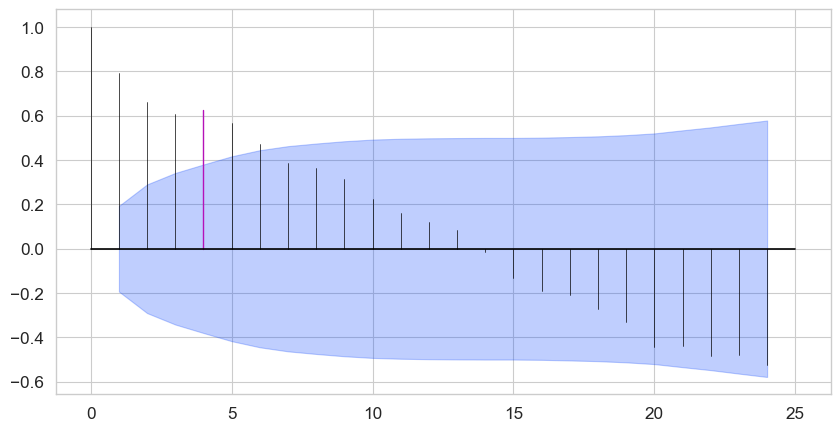

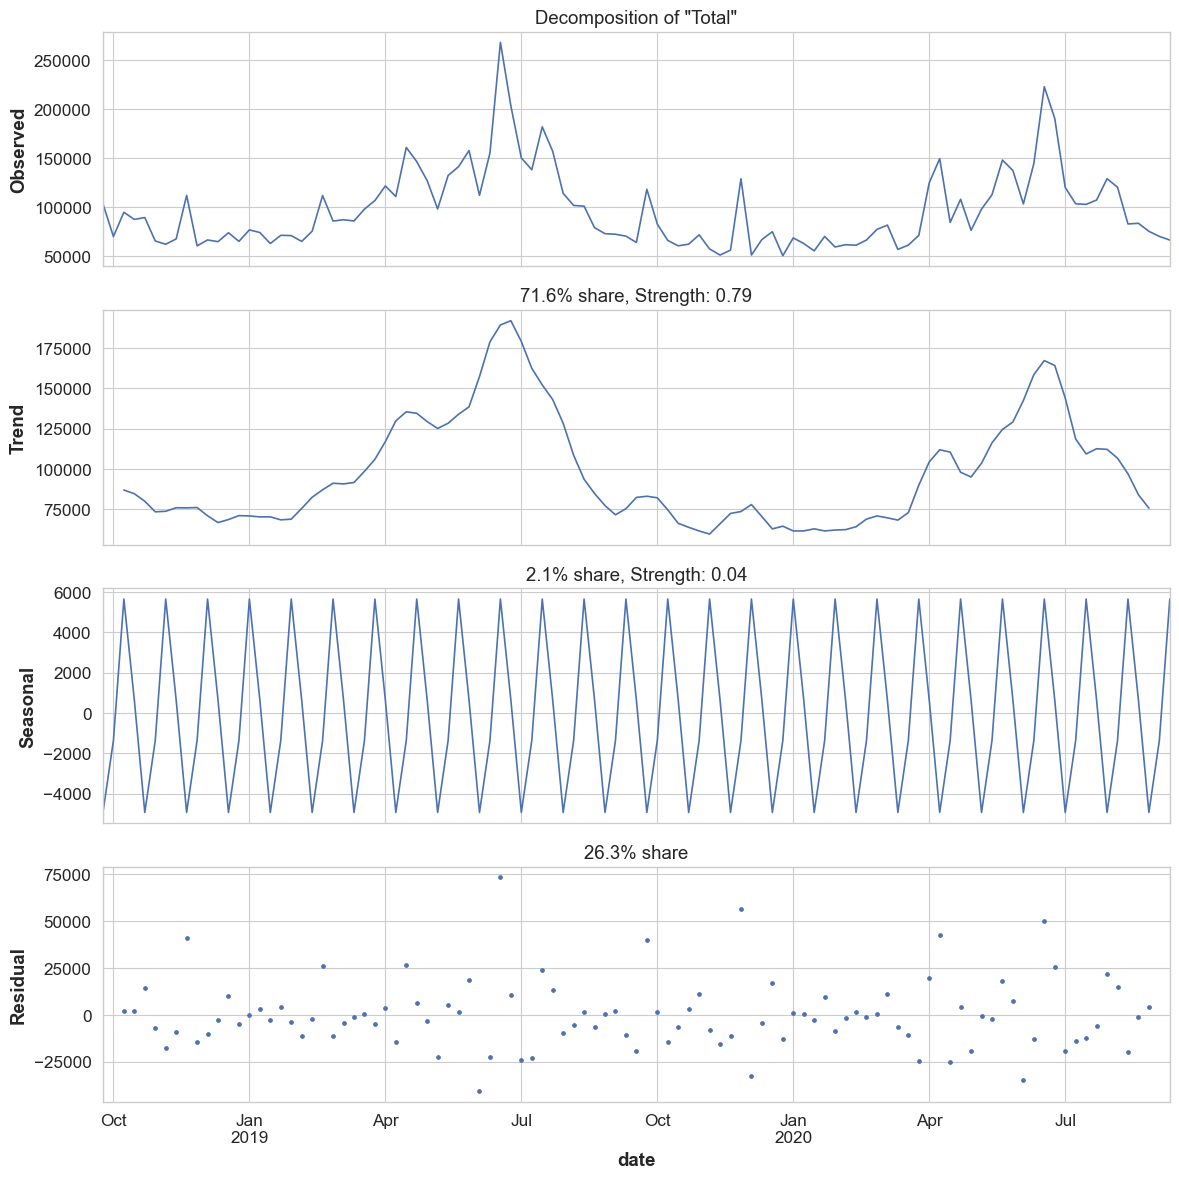

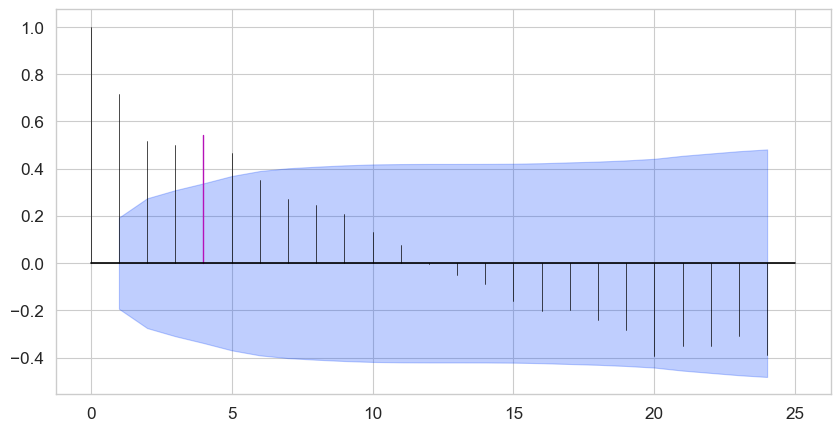

In [8]:
# Using the Darts package to check seasonality, ts decompositions, and ts autocorrelation plot

df_darts = TimeSeries.from_dataframe(df) 
for i in df_darts.columns:
    # print(i)
    m = check_seasonality(df_darts[i])[1]
    print(i, m)
    if check_seasonality(df_darts[i])[1] !=0:
        decomp_plot(df[i], 'img/{}_decomp.png'.format(i), period=m)
    plot_acf(df_darts[i], m=m)

## Answer II

+ Hoodie and Jacket are hightly correlated (both are winter clothes)
+ The rest of the types are also hightly correlated, especially Blouse and Dress
+ There seems to have dominated short-term seasonality around 1 month (4 weeks)
+ The long-term seasonality of 1 year are not easy to determine due to the lack of more cycles but are obvious in the graphs

## TS Forecasting

### Setup MLflow

In [9]:
print("MLflow Version:", mlflow.version.VERSION)
mlflow.set_tracking_uri("http://127.0.0.1:5000")      # remote
# mlflow.set_tracking_uri("file:/Users/tcp/Development/Projects/Bonusan/mlflow-demo/mlruns") # local
print("Tracking URI:", mlflow.tracking.get_tracking_uri())

MLflow Version: 2.8.1
Tracking URI: http://127.0.0.1:5000


### Baseline models

<Axes: title={'center': 'Data Train/Test Split Fold 1'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 1'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 2'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 2'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 3'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 3'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 4'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 4'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 5'}, xlabel='date'>

<Axes: title={'center': 'Data Train/Test Split Fold 5'}, xlabel='date'>

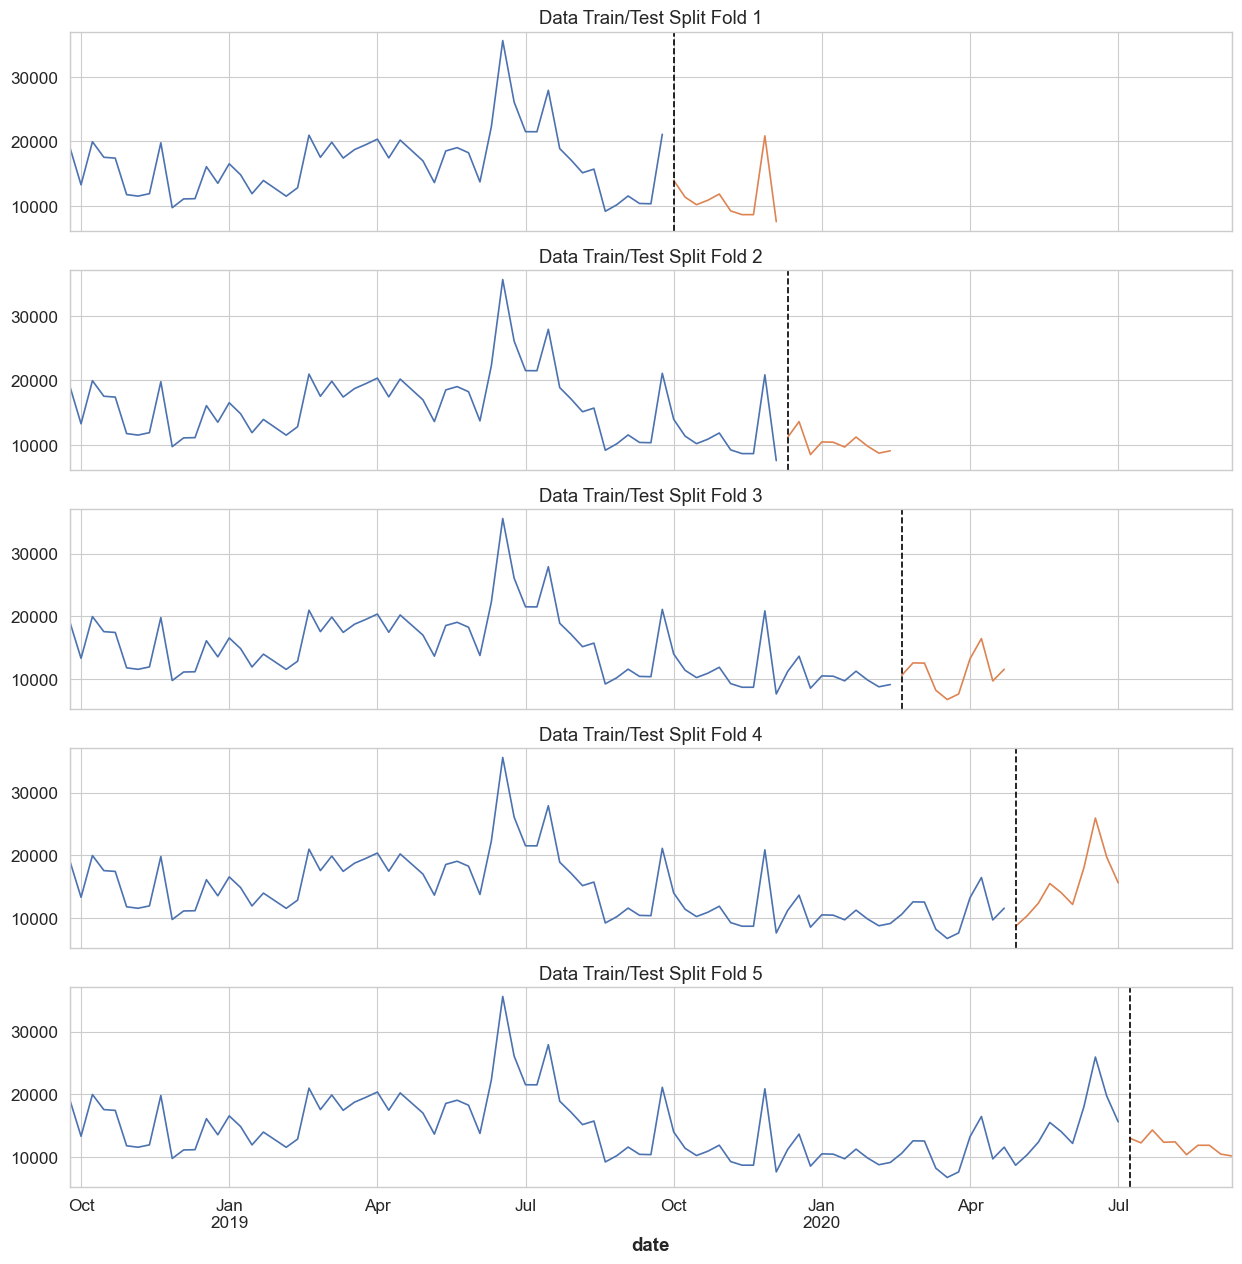

In [10]:
# Define TS K-fold CV

tss = TimeSeriesSplit(n_splits=5, test_size=10)
train_df = df['Blouse'].copy()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
cutoff_date = []
fold = 0
for train_idx, val_idx in tss.split(train_df):
    train_df.iloc[train_idx].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold + 1}')
    train_df.iloc[val_idx].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(train_df.iloc[val_idx].index.min(), color='black', ls='--')
    cutoff_date.append(train_df.iloc[val_idx].index.min())
    fold += 1
plt.savefig('img/kfold.png', dpi=300)
plt.show()

In [11]:
cutoff_date

[Timestamp('2019-10-03 00:00:00'),
 Timestamp('2019-12-12 00:00:00'),
 Timestamp('2020-02-20 00:00:00'),
 Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-07-09 00:00:00')]

In [12]:
model_dict = {
    "ExponentialSmoothing": ExponentialSmoothing(seasonal_periods=4),
    "AutoARIMA": AutoARIMA(),
    "ARIMA": ARIMA()
}

In [13]:
# defining a new experiment
experiment_name = 'TSForecast'
# returns experiment ID
try:
    # creating a new experiment
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [14]:
# starting an mlflow run, and tracking them under the experiment defined above

for m in model_dict:
    with mlflow.start_run(experiment_id=exp_id, run_name='TS_Base_Model_{}'.format(m)):

        mlflow.set_tag('Description', 'TS Forecast Baseline Models')
        mlflow.set_tags({'ProblemType': 'Forcasting', 
                        'ModelType': m, 
                        'ModelLibrary': 'Darts'})
        score = eval_model(train_df, model_dict[m])
        mlflow.log_metric('5-fold MAPE score', score)
    

1. Fold Training... 
model ExponentialSmoothing(seasonal_periods=4) obtains MAPE: 48.44%
2. Fold Training... 
model ExponentialSmoothing(seasonal_periods=4) obtains MAPE: 26.98%
3. Fold Training... 
model ExponentialSmoothing(seasonal_periods=4) obtains MAPE: 27.45%
4. Fold Training... 
model ExponentialSmoothing(seasonal_periods=4) obtains MAPE: 28.06%
5. Fold Training... 
model ExponentialSmoothing(seasonal_periods=4) obtains MAPE: 59.63%
CV MAPE score => 38.1117340154323


/Users/foton/miniconda3/envs/assignment_tc/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/foton/miniconda3/envs/assignment_tc/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/foton/miniconda3/envs/assignment_tc/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/foton/miniconda3/envs/assignment_tc/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/Users/foton/miniconda3/envs/assignment_tc/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



1. Fold Training... 
model AutoARIMA() obtains MAPE: 68.12%
2. Fold Training... 
model AutoARIMA() obtains MAPE: 47.22%
3. Fold Training... 
model AutoARIMA() obtains MAPE: 23.31%
4. Fold Training... 
model AutoARIMA() obtains MAPE: 27.01%
5. Fold Training... 
model AutoARIMA() obtains MAPE: 40.81%
CV MAPE score => 41.29476540072686
1. Fold Training... 
model ARIMA() obtains MAPE: 84.92%
2. Fold Training... 
model ARIMA() obtains MAPE: 21.18%
3. Fold Training... 
model ARIMA() obtains MAPE: 23.26%
4. Fold Training... 
model ARIMA() obtains MAPE: 29.23%
5. Fold Training... 
model ARIMA() obtains MAPE: 39.42%
CV MAPE score => 39.60045354115167


### Baseline Model Results

+ Three models (ExponentialSmoothing, AutoARIMA, ARIMA) show the 5-fold MAPE between 38-41%
+ Next step is to use Prophet to see if the MAPE could be decreased

# Prophet

+ Define holidays and sales periods

In [15]:
extra_holiday = []
for i in df.columns:
    temp = df.loc[df.groupby(df.index.year)[i].idxmax(), i].reset_index()['date']
    extra_holiday.append([i for i in temp.astype(str)])
extra_holiday = sorted(list(set(reduce(lambda x,y: x+y, extra_holiday))))

sales = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(extra_holiday),
  'lower_window': -2,
  'upper_window': 2,
})

In [16]:
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

18:40:00 - cmdstanpy - INFO - Chain [1] start processing
18:40:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:02 - cmdstanpy - INFO - Chain [1] start processing
18:40:02 - cmdstanpy - INFO - Chain [1] done processing
18:40:03 - cmdstanpy - INFO - Chain [1] start processing
18:40:03 - cmdstanpy - INFO - Chain [1] done processing
18:40:03 - cmdstanpy - INFO - Chain [1] start processing
18:40:03 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,6.004550e+06,2450.418239,2060.613324,0.165771,0.131736,0.181023,1.0
1,14 days,5.621574e+05,749.771555,606.613318,0.057608,0.035914,0.056452,1.0
2,21 days,1.091692e+07,3304.076407,2404.639626,0.216936,0.109246,0.210617,0.6
3,28 days,9.077537e+06,3012.895168,2191.189439,0.265632,0.087716,0.210291,0.8
4,35 days,6.942282e+06,2634.820992,1648.103486,0.195402,0.051141,0.153530,0.8


5-fold MAPE score: 0.18


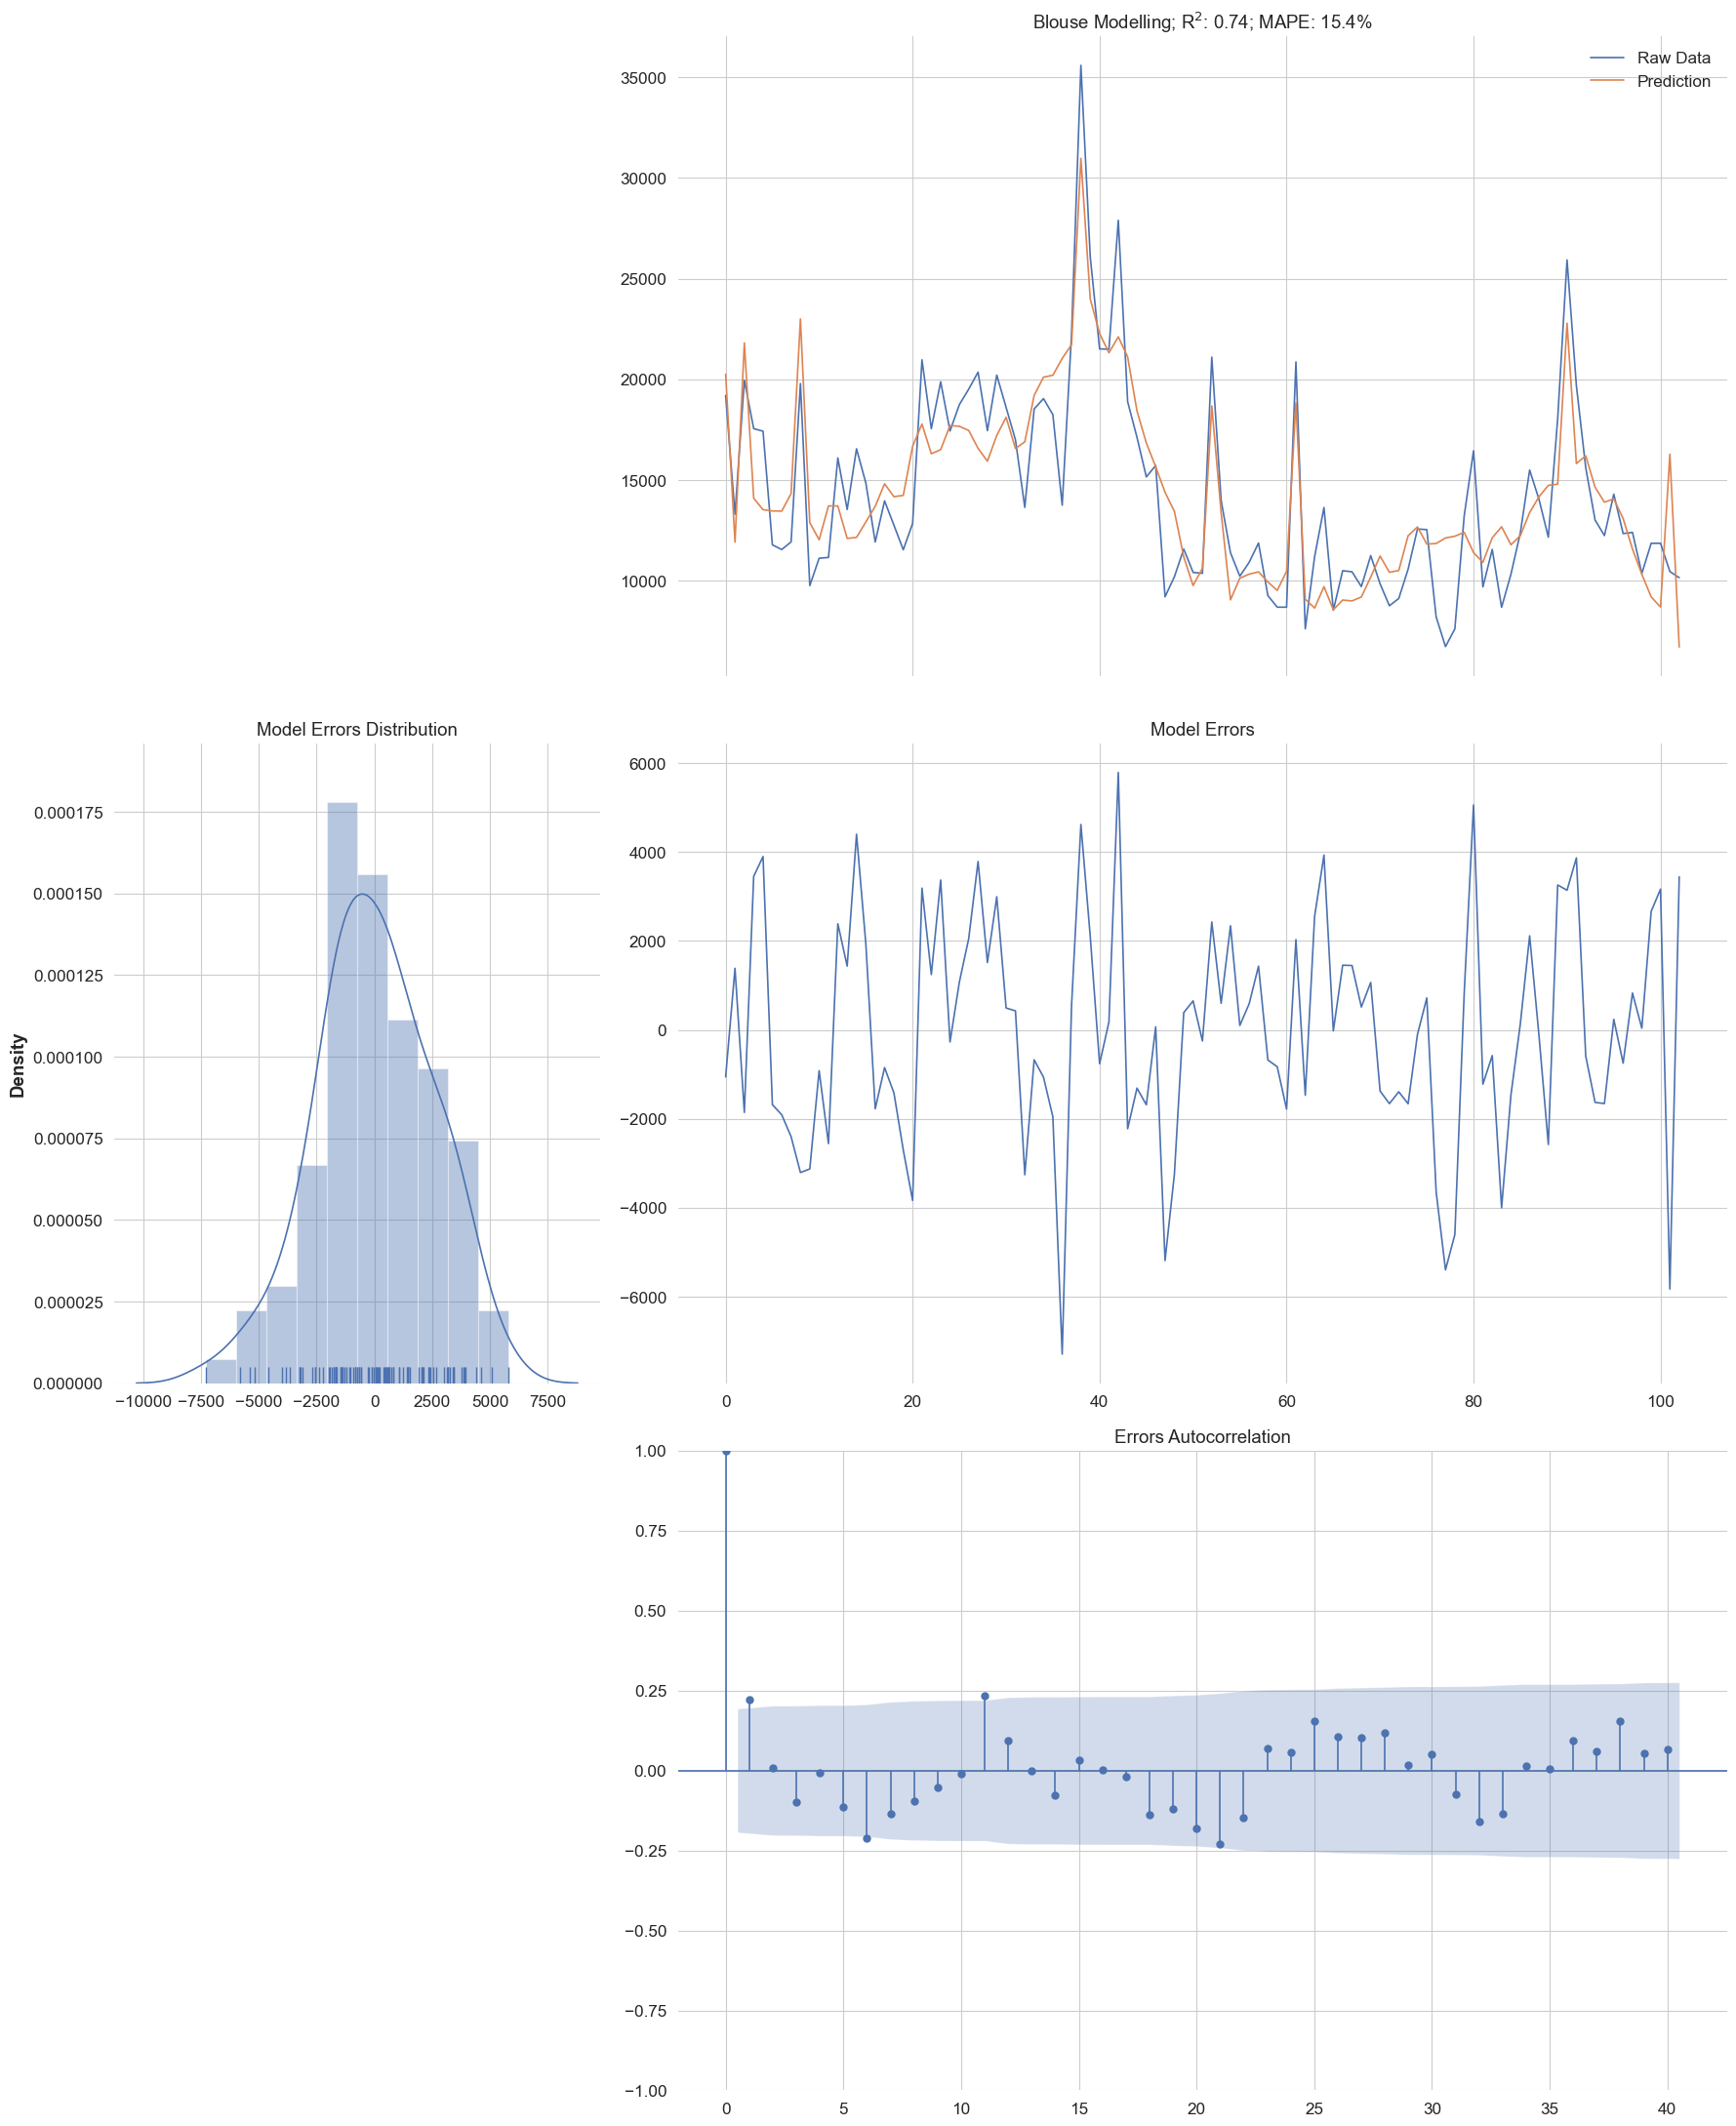

In [17]:
# Run model with mkflow
with mlflow.start_run(experiment_id=exp_id, run_name='TS_Prophet_Model'):

    mlflow.set_tag('Description', 'TS Forecast Prophet Models')
    mlflow.set_tags({'ProblemType': 'Forcasting', 
                    'ModelType': 'Prophet', 
                    'ModelLibrary': 'Prophet'})

    mlflow.log_artifacts('img')

    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False, 
                holidays=sales,
                interval_width=0.95)

    input_df = df.Blouse.copy().reset_index().rename(columns={"date":"ds", "Blouse":"y"})

    # add holidays and seasonality
    m.add_country_holidays(country_name='DE')
    m.add_seasonality(name='yearly', period=365, fourier_order=3, mode="multiplicative", prior_scale=5)
    m.add_seasonality(name='monthly', period=31, fourier_order=3, mode="multiplicative", prior_scale=1)

    # fitting and forcasting

    m.fit(input_df)
    future = m.make_future_dataframe(5, freq='W')
    forcast = m.predict(future)
    plot_plotly(m, forcast)
    plot_components_plotly(m, forcast)

    # k-fold forcasting error
    df_cv = cross_validation(m, cutoffs= cutoff_date, horizon = '5 W')
    df_cv_back = df_cv.copy()
    # df_cv_back.iloc[:, 1:5] = np.exp(df_cv.iloc[:, 1:5]-1)
    df_p = performance_metrics(df_cv_back)
    df_p
    score = np.mean(df_p.mape)
    print('5-fold MAPE score: {:.2f}'.format(score))

    mlflow.log_metric('Avg Validation 5-fold MAPE score', score)

    fig = error_plot(input_df, forcast, 'Blouse', 'img/Blouse_prophet.png', transform=False)
    

+ The training MAPE is 0.15 and validation MAPE is 0.18 (slightly overfitting)
+ Error dist. is skrewed towards the positive side meaning that some overestimations
+ Error Autocorrelation doesn't show strong seasonality left (only light hint on lag 2 and 11)
+ A few strong peaks are not well fitted -> Use log transformation to better fit the peaks

18:40:05 - cmdstanpy - INFO - Chain [1] start processing
18:40:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

18:40:05 - cmdstanpy - INFO - Chain [1] start processing
18:40:05 - cmdstanpy - INFO - Chain [1] done processing
18:40:05 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing
18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing
18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing
18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:06 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,5.083934e+06,2254.758164,1749.517330,0.140205,0.063241,0.156361,0.8
1,14 days,1.914786e+06,1383.757938,1141.327854,0.100047,0.073125,0.103556,1.0
2,21 days,1.188366e+07,3447.267765,2580.530106,0.228247,0.099253,0.229660,0.6
3,28 days,1.173408e+07,3425.504564,2840.122481,0.311360,0.136589,0.265712,0.8
4,35 days,5.077998e+06,2253.441288,1227.517790,0.152211,0.040403,0.120135,0.8


Avg Validation 5-fold MAPE score: 0.19


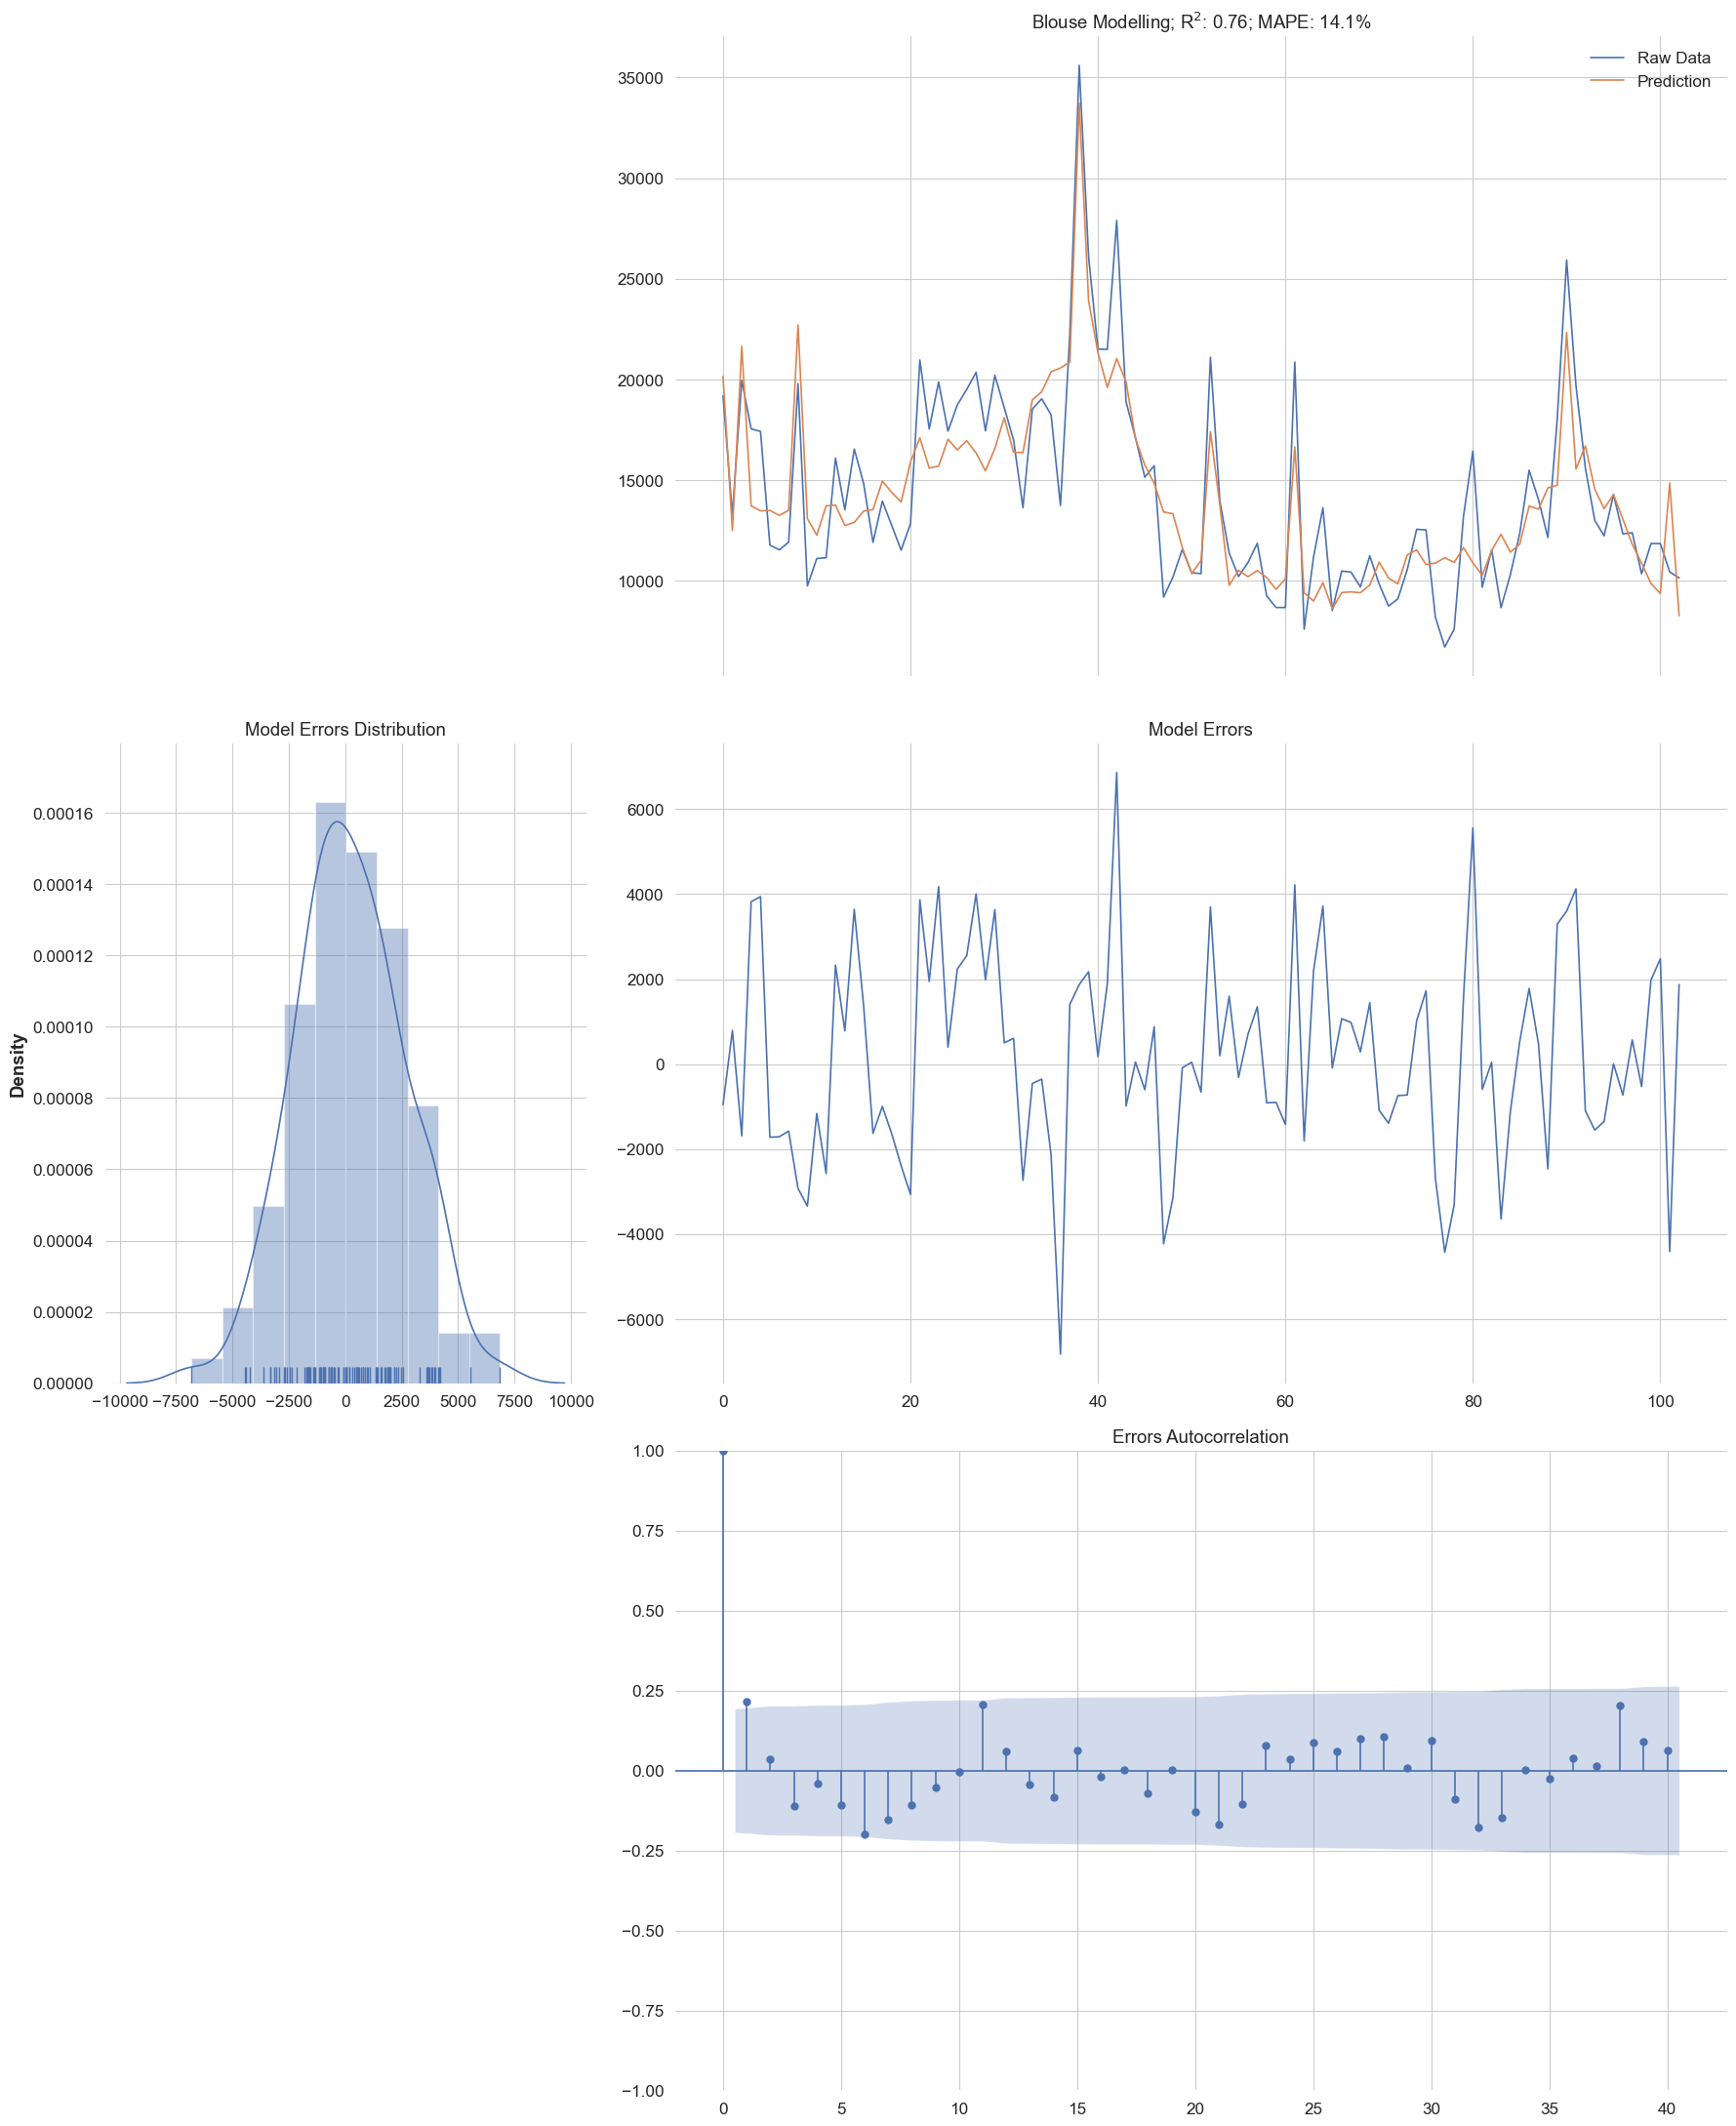

In [18]:
# Run model with log transform
with mlflow.start_run(experiment_id=exp_id, run_name='TS_Prophet_Model_trans'):

    mlflow.set_tag('Description', 'TS Forecast Prophet Models')
    mlflow.set_tags({'ProblemType': 'Forcasting', 
                    'ModelType': 'Prophet', 
                    'ModelLibrary': 'Prophet'})

    mlflow.log_artifacts('img')

    m = Prophet(yearly_seasonality=False,
                weekly_seasonality=False, 
                holidays=sales,
                interval_width=0.95)

    # Using log transformation
    df_transfrom = df.Blouse.copy().apply(lambda x: 1+np.log(x))
    input_df = df_transfrom.reset_index().rename(columns={"date":"ds", "Blouse":"y"})

    # add holidays and seasonality
    m.add_country_holidays(country_name='DE')
    m.add_seasonality(name='yearly', period=365, fourier_order=3, mode="multiplicative", prior_scale=5)
    m.add_seasonality(name='monthly', period=31, fourier_order=3, mode="multiplicative", prior_scale=1)

    # fitting and forcasting

    m.fit(input_df)
    future = m.make_future_dataframe(5, freq='W')
    forcast = m.predict(future)
    plot_plotly(m, forcast)
    plot_components_plotly(m, forcast)

    # k-fold forcasting error
    df_cv = cross_validation(m, cutoffs= cutoff_date, horizon = '5 W')
    df_cv_back = df_cv.copy()
    df_cv_back.iloc[:, 1:5] = np.exp(df_cv.iloc[:, 1:5]-1)
    df_p = performance_metrics(df_cv_back)
    df_p
    score = np.mean(df_p.mape)
    print('Avg Validation 5-fold MAPE score: {:.2f}'.format(score))

    mlflow.log_metric('5-fold MAPE score', score)

    fig = error_plot(input_df, forcast, 'Blouse', 'img/Blouse_prophet_trans.png', transform=True)
    

In [34]:
df.Blouse.tail(5)
output = forcast.copy().set_index('ds')
output.tail(5)[['yhat_lower', 'yhat', 'yhat_upper']]\
    .apply(lambda x: np.exp(x-1), axis=1).reset_index().to_csv('5weeks_prediction.csv')

date
2020-08-13    10351
2020-08-20    11852
2020-08-27    11851
2020-09-03    10448
2020-09-10    10143
Name: Blouse, dtype: int64

+ The (data-transformed) training MAPE is 0.14 and validation MAPE is 0.19 (slightly overfitting)
+ Error dist. is more close to Gaussian
+ Error Autocorrelation doesn't show strong seasonality left
+ Only few peaks are not well fitted (slightly better than the previous results)